In [2]:
using ArchGDAL
using LinearAlgebra
using DataFrames
using Dates
using Pipe
using Plots
using Rasters
using Serialization

include("util.jl")

harversine_dist

### Read WorldPop data

In [2]:
agg_scale = 1000

1000

In [3]:
path = "../data/zaf_f_5_2020_constrained.tif"
f_5_zaf = read(Raster(path))
f_5_zaf = replace_missing(f_5_zaf, 0)
f_5_zaf_agg = Rasters.aggregate(sum, f_5_zaf, agg_scale; skipmissingval=true)
f_5_zaf = nothing

In [4]:
path = "../data/zaf_m_5_2020_constrained.tif"
m_5_zaf = read(Raster(path))
m_5_zaf = replace_missing(m_5_zaf, 0)
m_5_zaf_agg = Rasters.aggregate(sum, m_5_zaf, agg_scale; skipmissingval=true)
m_5_zaf = nothing

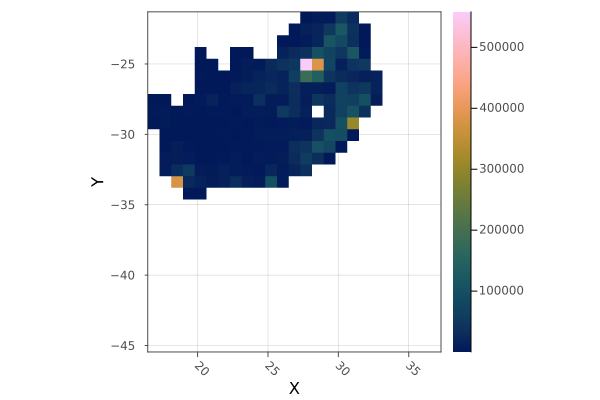

In [5]:
zaf_5_agg = f_5_zaf_agg + m_5_zaf_agg 
plot(zaf_5_agg)

In [8]:
# write("../data/zaf_5_2020.tif", zaf_5_agg)

## Read and manipulate data 

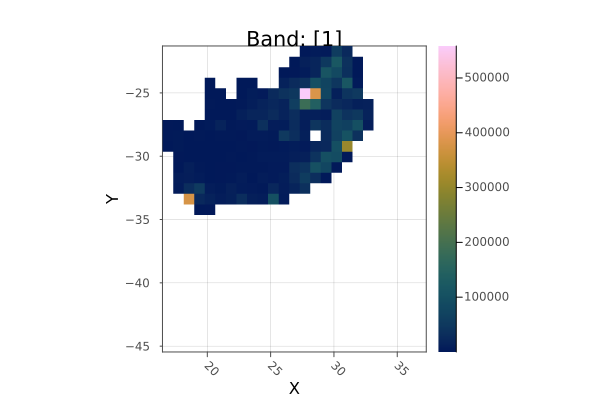

In [3]:
path = "../data/zaf_5_agg1000_2020.tif"
zaf_5 = read(Raster(path))
plot(zaf_5)

In [10]:
df = raster_to_df(zaf_5)
df |> size |> println
println("Population size before filtering :", df[:, :value] |> sum)

df[!, :value] = @pipe df[:, :value] .|> round(_; digits=0)
cond = df[:, :value] .>= 100
df = df[cond, :]
df |> size |> println

df = sort(df, :value; rev=true)
println("Population size after filtering :", df[:, :value] |> sum)
nothing

(725, 3)
Population size before filtering :5.696374e6
(185, 3)
Population size after filtering :5.69551e6


In [11]:
# Effective immunize coverage is assumed to be 90% 
df_ana = copy(df)
df_ana[!, :unvac] = @pipe (df_ana[:, :value]*0.1) .|> round(_, digits=0) .|> Int64
nothing

### Prepare parameter 

In [12]:
pop = df_ana[:, :unvac]
mat = df_ana[:, [:lat, :lon]] |> Matrix
nothing

In [13]:
# Calculate distance matrix
n_point = size(df_ana)[1]
d_mat = fill(0., n_point, n_point)
for i in 1:n_point, j in 1:n_point
    ϕ1, λ1 = mat[i, :]
    ϕ2, λ2 = mat[j, :]
    d_mat[i,j] = harversine_dist(ϕ1, λ1, ϕ2, λ2)
end

# Calculate sij
s_mat = fill(0., n_point, n_point)
for i in 1:n_point, j in 1:n_point
    d_i = d_mat[i, :]
    cond = d_i .< d_i[j] # exclude the destination area.
    s_mat[i,j] = sum(pop[cond]) - pop[i]
end
s_mat[ diagind(s_mat)] .= 0

# Calculate πij
π_mat = fill(0., n_point, n_point)
for i in 1:n_point, j in 1:n_point
    π_mat[i, j] = pop[i]*pop[j]/(pop[i] + s_mat[i,j])/(pop[i] + pop[j] + s_mat[i,j])
end
π_mat[diagind(π_mat)] .= 0
nothing

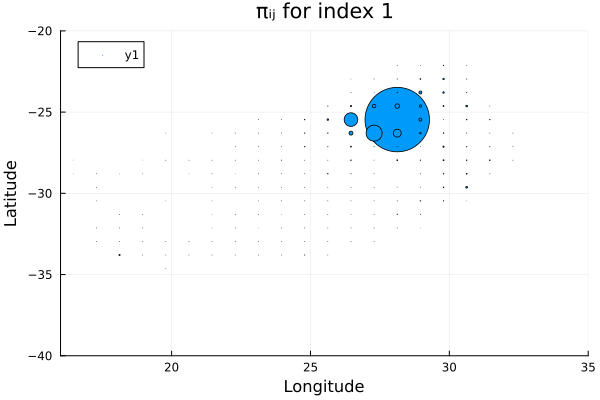

In [18]:
ind = 1
scatter(df[:, :lon], df[:, :lat], 
    markersize=π_mat[ind, :]*100, 
    xlabel="Longitude", ylabel="Latitude",
    title="πᵢⱼ for index $ind",
    xlim=[16, 35], ylim=[-40, -20],
    fmt=:png
)

In [15]:
spatial_p = (pop=pop, π_mat=π_mat, df=df_ana)
serialize("../dt_tmp/test.ser", spatial_p)

In [16]:
spatial_p1 = deserialize("../dt_tmp_fix/pop_pi_agg1000_10unvac.ser")
nothing

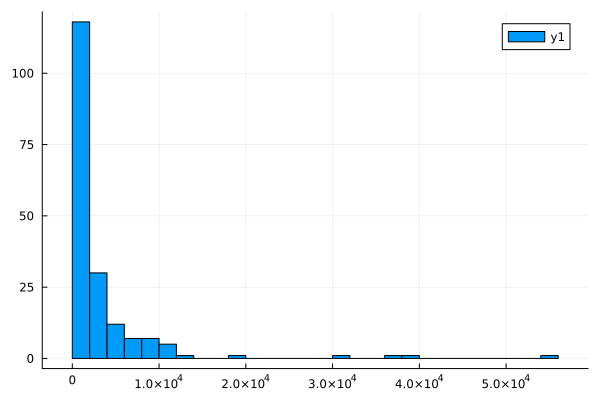

In [17]:
histogram(spatial_p1.pop)